In [45]:
# Install all necessary libraries for our XAI framework
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib alibi captum pdpbox eli5


Dataset prep


In [46]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Change the path to where your dataset is stored in Drive
dataset_path = '/content/drive/MyDrive/Crop_recommendation.csv'
df = pd.read_csv(dataset_path)

# Preview first rows
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

In [47]:
# Check for data quality issues
# Check dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Show basic dataset info
print("\nDataset info:")
df.info()

# Quick look at unique crop types
print("\nUnique crops (x)=target labels):", df['label'].unique())
print("Total crop classes:", df['label'].nunique())


Dataset shape: (2200, 8)

Missing values per column:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Number of duplicate rows: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Unique crops (x)=target labels): ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango'

In [58]:
from sklearn.preprocessing import LabelEncoder
import joblib

# --- Separate features (X) and target (y) ---
X = df.drop('label', axis=1)  # all feature columns
y = df['label']               # target column (crop names)

# --- Fit LabelEncoder on the FULL dataset (train + test labels) ---
label_encoder = LabelEncoder()
label_encoder.fit(y)  # Fit on ALL labels so no unseen label issue

# --- Transform labels ---
y_encoded = label_encoder.transform(y)

# --- Save the rebuilt LabelEncoder for use in SHAP, LIME, and MLP ---
save_path = '/content/drive/MyDrive/'
joblib.dump(label_encoder, save_path + 'label_encoder.pkl')

# --- Show mapping (Crop Name -> Code) for verification ---
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Crop Label Mapping (Crop Name -> Code):")
for crop, code in label_mapping.items():
    print(f"{crop}: {code}")

# Check feature and encoded label shapes
print("\nFeatures shape:", X.shape)
print("Encoded labels shape:", y_encoded.shape)
print("\nLabelEncoder rebuilt and saved successfully!")


Crop Label Mapping (Crop Name -> Code):
apple: 0
banana: 1
blackgram: 2
chickpea: 3
coconut: 4
coffee: 5
cotton: 6
grapes: 7
jute: 8
kidneybeans: 9
lentil: 10
maize: 11
mango: 12
mothbeans: 13
mungbean: 14
muskmelon: 15
orange: 16
papaya: 17
pigeonpeas: 18
pomegranate: 19
rice: 20
watermelon: 21

Features shape: (2200, 7)
Encoded labels shape: (2200,)

LabelEncoder rebuilt and saved successfully!


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# --- Split the data (80% train, 20% test) ---
# y_encoded is already fully encoded using the rebuilt label_encoder
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# --- Scale the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Feature Mean (approx):", X_train_scaled.mean(axis=0))
print("Scaled Feature Std (approx):", X_train_scaled.std(axis=0))

# --- Save all preprocessed files (overwrite old ones to avoid mismatch) ---
save_path = '/content/drive/MyDrive/'

joblib.dump(X_train_scaled, save_path + 'X_train.pkl')
joblib.dump(X_test_scaled, save_path + 'X_test.pkl')
joblib.dump(y_train, save_path + 'y_train.pkl')
joblib.dump(y_test, save_path + 'y_test.pkl')
joblib.dump(scaler, save_path + 'scaler.pkl')
joblib.dump(label_encoder, save_path + 'label_encoder.pkl')  # now the fixed one

print(f"\nAll preprocessed files saved in: {save_path}")


Training set size: 1760
Testing set size: 440

Scaled Feature Mean (approx): [ 2.82602224e-17  8.07434927e-17  5.55111512e-17 -2.82602224e-16
 -1.46347581e-16 -4.52163559e-16  2.22044605e-16]
Scaled Feature Std (approx): [1. 1. 1. 1. 1. 1. 1.]

All preprocessed files saved in: /content/drive/MyDrive/


In [60]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# --- Load preprocessed data (already numeric labels) ---
save_path = '/content/drive/MyDrive/'

X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_train = joblib.load(save_path + 'y_train.pkl')  # encoded labels
y_test = joblib.load(save_path + 'y_test.pkl')    # encoded labels

# --- Initialize models ---
models = {
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42, use_label_encoder=False),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42)
}

# --- Train and evaluate each model ---
model_accuracies = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)  # uses encoded labels
    y_pred = model.predict(X_test)  # predictions (encoded)
    acc = accuracy_score(y_test, y_pred)  # compare encoded-to-encoded
    model_accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

    # Save the trained model
    joblib.dump(model, save_path + f"{name}_model.pkl")

print("\nAll models trained and saved successfully!")
print("Model Accuracies:", model_accuracies)



Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9932

Training RandomForest...
RandomForest Accuracy: 0.9955

Training SVM...
SVM Accuracy: 0.9818

Training MLP...
MLP Accuracy: 0.9909

Training LogisticRegression...
LogisticRegression Accuracy: 0.9727

All models trained and saved successfully!
Model Accuracies: {'XGBoost': 0.9931818181818182, 'RandomForest': 0.9954545454545455, 'SVM': 0.9818181818181818, 'MLP': 0.990909090909091, 'LogisticRegression': 0.9727272727272728}


Singular model training

Final SHAP values shape: (440, 7)
X_test_df shape: (440, 7)

Generating SHAP summary plot...


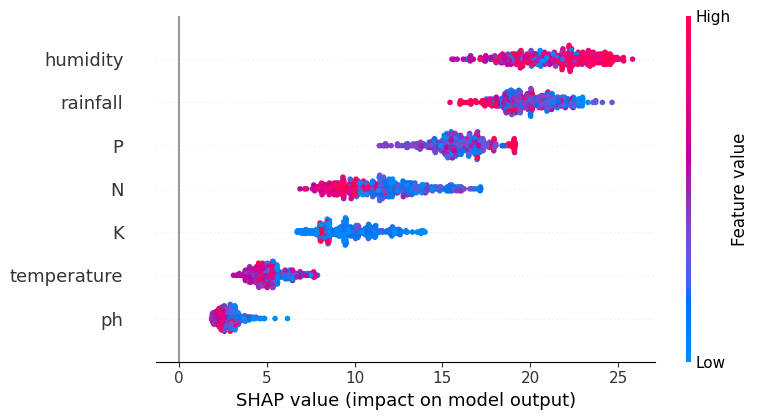


Explaining instance #10
True Crop: watermelon | Predicted Crop: watermelon


In [61]:
import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Load model and data ---
save_path = '/content/drive/MyDrive/'
xgb_model = joblib.load(save_path + 'XGBoost_model.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- Create SHAP Explainer ---
explainer = shap.TreeExplainer(xgb_model)
shap_exp = explainer(X_test_df)

# --- Compute global SHAP values ---
shap_values = np.abs(shap_exp.values).sum(axis=2)  # (440, 7)
print("Final SHAP values shape:", shap_values.shape)
print("X_test_df shape:", X_test_df.shape)

# --- GLOBAL SHAP SUMMARY PLOT ---
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_df, feature_names=feature_names, show=True)

# --- LOCAL SHAP FORCE PLOT (Safe Version) ---
instance_idx = 10
instance_data = X_test_df.iloc[instance_idx]
instance_true_class = y_test[instance_idx]
instance_pred_class = xgb_model.predict(instance_data.values.reshape(1, -1))[0]

# Try decoding, but fall back to codes if any unseen labels occur
try:
    true_crop = label_encoder.inverse_transform([instance_true_class])[0]
except ValueError:
    true_crop = f"ClassCode-{instance_true_class}"

try:
    pred_crop = label_encoder.inverse_transform([instance_pred_class])[0]
except ValueError:
    pred_crop = f"ClassCode-{instance_pred_class}"

print(f"\nExplaining instance #{instance_idx}")
print(f"True Crop: {true_crop} | Predicted Crop: {pred_crop}")

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[instance_pred_class],
    shap_values=shap_exp.values[instance_idx, :, instance_pred_class],
    features=instance_data.values,
    feature_names=feature_names
)


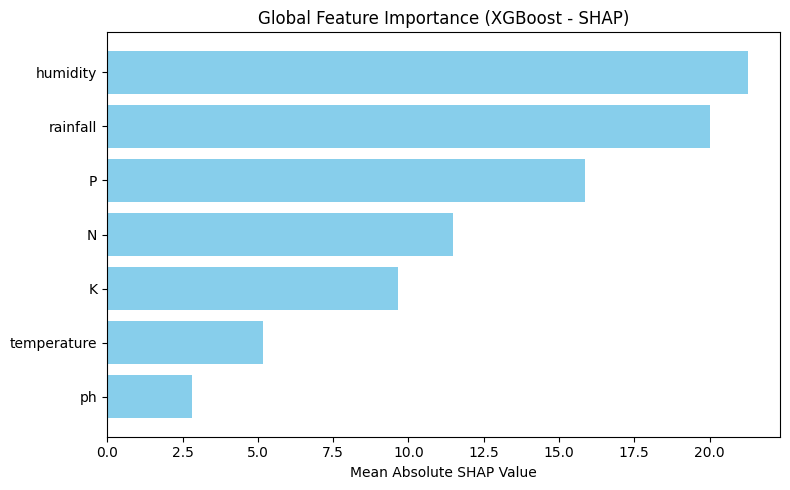

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute mean absolute SHAP value for each feature ---
feature_importance = np.mean(np.abs(shap_values), axis=0)  # average across samples
sorted_idx = np.argsort(feature_importance)[::-1]  # sort by importance descending

sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# --- Plot horizontal bar chart ---
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.gca().invert_yaxis()  # most important at top
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Global Feature Importance (XGBoost - SHAP)")
plt.tight_layout()

plt.show()


In [53]:
!pip install lime

In [62]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# --- Prepare data for LIME ---
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=label_encoder.classes_,  # these are crop names, safe as long as encoder was rebuilt
    mode='classification'
)

# Choose the same instance as SHAP (index 10)
instance_idx = 10
instance = X_test[instance_idx].reshape(1, -1)

# Generate explanation
lime_exp = lime_explainer.explain_instance(
    data_row=X_test[instance_idx],
    predict_fn=xgb_model.predict_proba,
    num_features=7  # show all features
)

# Get predicted class (encoded)
pred_class = xgb_model.predict(instance)[0]

# Try decoding crop name, fallback to class code if unseen label error occurs
try:
    pred_crop = label_encoder.inverse_transform([pred_class])[0]
except ValueError:
    pred_crop = f"ClassCode-{pred_class}"

# Show explanation results
print(f"\nLIME Explanation for instance #{instance_idx} (Predicted crop: {pred_crop})")
for feature, weight in lime_exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Interactive HTML visualization (works in Colab)
lime_exp.show_in_notebook(show_table=True)



LIME Explanation for instance #10 (Predicted crop: watermelon)
N > 0.93: 0.1366
P <= -0.77: -0.0792
rainfall <= -0.71: -0.0208
0.41 < humidity <= 0.83: 0.0112
-0.56 < temperature <= -0.02: 0.0054
K > 0.02: 0.0039
-0.66 < ph <= -0.05: 0.0014


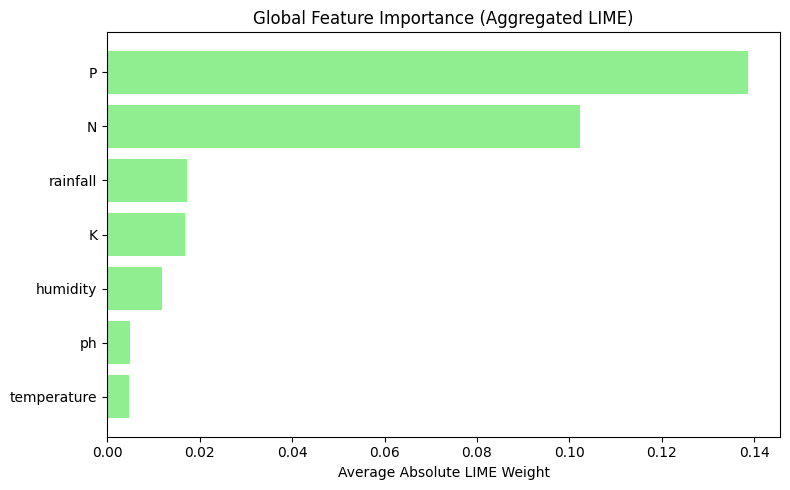

In [55]:
import random
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Step 2: Aggregated Global LIME Importance ---

# Sample 100 random instances from test set (adjust to len(X_test) for all samples)
num_samples = len(X_test)
sample_indices = random.sample(range(len(X_test)), num_samples)

# Initialize a dictionary to collect contributions
feature_contributions = {feature: [] for feature in feature_names}

# Loop over sampled instances and aggregate LIME contributions
for idx in sample_indices:
    lime_exp = lime_explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=xgb_model.predict_proba,
        num_features=len(feature_names)
    )
    for feature, weight in lime_exp.as_list():
        # Use regex to extract only the feature name (ignore thresholds like '<= 0.5')
        match = re.match(r"([a-zA-Z_]+)", feature)
        if match:
            clean_feature = match.group(1)
            feature_contributions[clean_feature].append(abs(weight))

# Compute average importance for each feature
avg_importance = {feature: np.mean(weights) for feature, weights in feature_contributions.items()}

# Sort features by importance (descending order)
sorted_features = sorted(avg_importance, key=avg_importance.get, reverse=True)
sorted_importance = [avg_importance[f] for f in sorted_features]

# --- Plot the global importance chart ---
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importance, color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Average Absolute LIME Weight")
plt.title("Global Feature Importance (Aggregated LIME)")
plt.tight_layout()

# Save chart to Google Drive
plt.savefig("/content/drive/MyDrive/global_lime_importance_bar.png", dpi=300)
plt.show()


In [56]:
import pandas as pd

# Create DataFrame for average LIME weights
lime_importance_df = pd.DataFrame({
    "Feature": sorted_features,
    "Average_LIME_Weight": sorted_importance
})

# Display the DataFrame for further use
print("\nGlobal Feature Importance (Aggregated LIME) - Exact Values:")
display(lime_importance_df)



Global Feature Importance (Aggregated LIME) - Exact Values:


Feature  Average_LIME_Weight
0            P             0.138647
1            N             0.102366
2     rainfall             0.017271
3            K             0.016757
4     humidity             0.011759
5           ph             0.004973
6  temperature             0.004778

Psuedo surrogate MLP model to replace XGboost in IG training and implementation

In [63]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# --- Scale features (if not already scaled) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DO NOT re-transform labels — y_train and y_test are already numeric codes!
y_train_encoded = y_train  # already encoded
y_test_encoded = y_test    # already encoded

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# --- Define a simple MLP model ---
class SurrogateMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=len(label_encoder.classes_)):
        super(SurrogateMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
input_dim = X_train_tensor.shape[1]
output_dim = len(label_encoder.classes_)
mlp_model = SurrogateMLP(input_dim, hidden_dim=64, output_dim=output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# --- Train the model ---
epochs = 50
mlp_model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --- Evaluate accuracy on test set ---
mlp_model.eval()
with torch.no_grad():
    test_preds = torch.argmax(mlp_model(X_test_tensor), dim=1)
    accuracy = (test_preds == y_test_tensor).float().mean().item()
print(f"Surrogate MLP Test Accuracy: {accuracy:.4f}")


Epoch 10/50, Loss: 1.7580
Epoch 20/50, Loss: 0.7811
Epoch 30/50, Loss: 0.3974
Epoch 40/50, Loss: 0.2394
Epoch 50/50, Loss: 0.1661
Surrogate MLP Test Accuracy: 0.9705


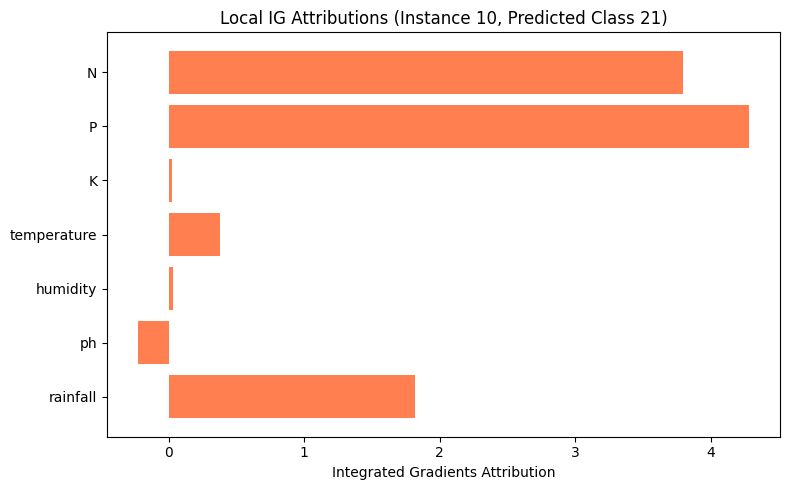


Exact IG Attributions (Instance 10):
N: 3.795443
P: 4.285505
K: 0.028645
temperature: 0.376619
humidity: 0.032519
ph: -0.227025
rainfall: 1.820386


In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Integrated Gradients Function ---
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a single input and target class.

    Args:
        model: Trained PyTorch model (mlp_model).
        input_tensor: Tensor of shape (1, num_features) for the instance.
        target_class: Target class index for which to compute attribution.
        baseline: Baseline tensor of same shape as input (default: zeros).
        steps: Number of interpolation steps between baseline and input.

    Returns:
        attributions: Tensor of shape (num_features,) with feature attributions.
    """
    model.eval()

    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    # Scale inputs from baseline to actual input
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)  # shape: (steps+1, num_features)

    scaled_inputs.requires_grad = True

    # Forward pass for all scaled inputs
    outputs = model(scaled_inputs)
    target_outputs = outputs[:, target_class]

    # Compute gradients
    grads = torch.autograd.grad(torch.sum(target_outputs), scaled_inputs)[0]

    # Average gradients (exclude the baseline step)
    avg_grads = grads[:-1].mean(dim=0)

    # Integrated Gradients: (input - baseline) * average gradient
    attributions = (input_tensor - baseline).squeeze() * avg_grads

    return attributions.detach().cpu().numpy()

# --- Select instance for IG (index 10, same as SHAP and LIME) ---
instance_idx = 10
instance = X_test_tensor[instance_idx].unsqueeze(0)  # shape (1, num_features)
pred_class = torch.argmax(mlp_model(instance), dim=1).item()

# Compute Integrated Gradients for this instance
ig_attributions = integrated_gradients(mlp_model, instance, target_class=pred_class)

# --- Visualize feature attributions ---
feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
plt.figure(figsize=(8, 5))
plt.barh(feature_names, ig_attributions, color='coral')
plt.gca().invert_yaxis()
plt.xlabel("Integrated Gradients Attribution")
plt.title(f"Local IG Attributions (Instance {instance_idx}, Predicted Class {pred_class})")
plt.tight_layout()
plt.show()

# Print exact attribution values
print("\nExact IG Attributions (Instance 10):")
for feature, value in zip(feature_names, ig_attributions):
    print(f"{feature}: {value:.6f}")


IG implementation using the instance MLP for XGB

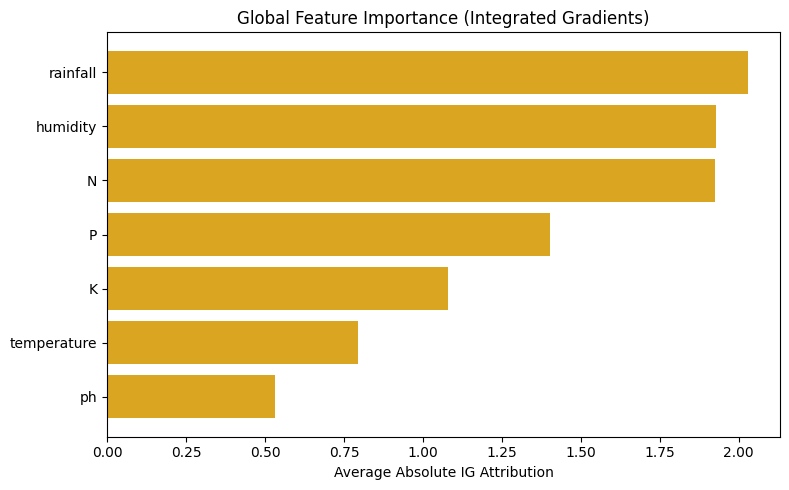


Global Feature Importance (Integrated Gradients) - Exact Values:


Feature  Average_IG_Attribution
0     rainfall                2.029150
1     humidity                1.928628
2            N                1.925386
3            P                1.401198
4            K                1.080101
5  temperature                0.793245
6           ph                0.531051

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute IG for all test samples ---
all_ig_attributions = []

for i in range(len(X_test_tensor)):
    instance = X_test_tensor[i].unsqueeze(0)  # shape (1, num_features)
    pred_class = torch.argmax(mlp_model(instance), dim=1).item()

    ig_attr = integrated_gradients(mlp_model, instance, target_class=pred_class)
    all_ig_attributions.append(np.abs(ig_attr))  # take absolute to measure magnitude

# Convert to array and average over all test instances
all_ig_attributions = np.array(all_ig_attributions)  # shape (num_samples, num_features)
avg_ig_importance = np.mean(all_ig_attributions, axis=0)  # shape (num_features,)

# Sort by importance
sorted_idx = np.argsort(avg_ig_importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importance = avg_ig_importance[sorted_idx]

# --- Plot Global IG Importance ---
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importance, color='goldenrod')
plt.gca().invert_yaxis()
plt.xlabel("Average Absolute IG Attribution")
plt.title("Global Feature Importance (Integrated Gradients)")
plt.tight_layout()

# Save plot
plt.savefig("/content/drive/MyDrive/global_ig_importance_bar.png", dpi=300)
plt.show()

# --- Display exact values in a table ---
import pandas as pd
ig_importance_df = pd.DataFrame({
    "Feature": sorted_features,
    "Average_IG_Attribution": sorted_importance
})
print("\nGlobal Feature Importance (Integrated Gradients) - Exact Values:")
display(ig_importance_df)


Shap implementation over random forest

Random Forest SHAP values shape: (440, 7)
X_test_df shape: (440, 7)

Generating SHAP summary plot for Random Forest...


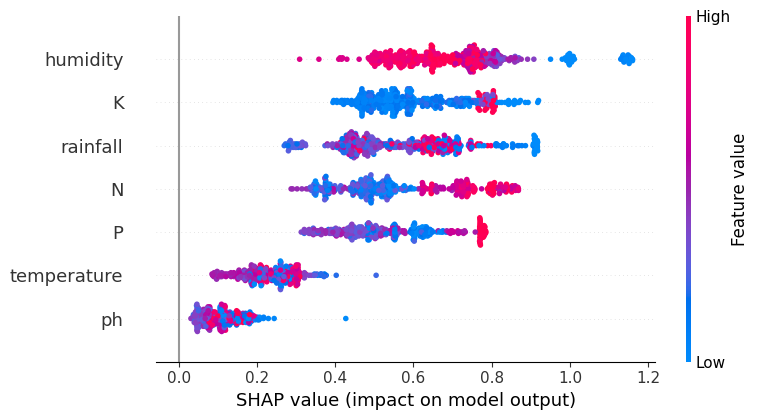


Explaining instance #10 for Random Forest
True Crop: watermelon | Predicted Crop: watermelon


In [66]:
import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Load Random Forest model and test data ---
save_path = '/content/drive/MyDrive/'
rf_model = joblib.load(save_path + 'RandomForest_model.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- Create SHAP TreeExplainer for Random Forest ---
explainer_rf = shap.TreeExplainer(rf_model)
shap_exp_rf = explainer_rf(X_test_df)

# --- Global SHAP values (sum absolute values across all classes) ---
shap_values_rf = np.abs(shap_exp_rf.values).sum(axis=2)  # shape: (num_samples, num_features)

print("Random Forest SHAP values shape:", shap_values_rf.shape)
print("X_test_df shape:", X_test_df.shape)

# --- Global SHAP Summary Plot ---
print("\nGenerating SHAP summary plot for Random Forest...")
shap.summary_plot(shap_values_rf, X_test_df, feature_names=feature_names, show=True)

# --- Local SHAP Force Plot (Instance 10, like we did before) ---
instance_idx = 10
instance_data = X_test_df.iloc[instance_idx]
instance_true_class = y_test[instance_idx]
instance_pred_class = rf_model.predict(instance_data.values.reshape(1, -1))[0]

# Safe decoding for crop names
try:
    true_crop = label_encoder.inverse_transform([instance_true_class])[0]
except ValueError:
    true_crop = f"ClassCode-{instance_true_class}"
try:
    pred_crop = label_encoder.inverse_transform([instance_pred_class])[0]
except ValueError:
    pred_crop = f"ClassCode-{instance_pred_class}"

print(f"\nExplaining instance #{instance_idx} for Random Forest")
print(f"True Crop: {true_crop} | Predicted Crop: {pred_crop}")

shap.initjs()
shap.force_plot(
    base_value=explainer_rf.expected_value[instance_pred_class],
    shap_values=shap_exp_rf.values[instance_idx, :, instance_pred_class],
    features=instance_data.values,
    feature_names=feature_names
)


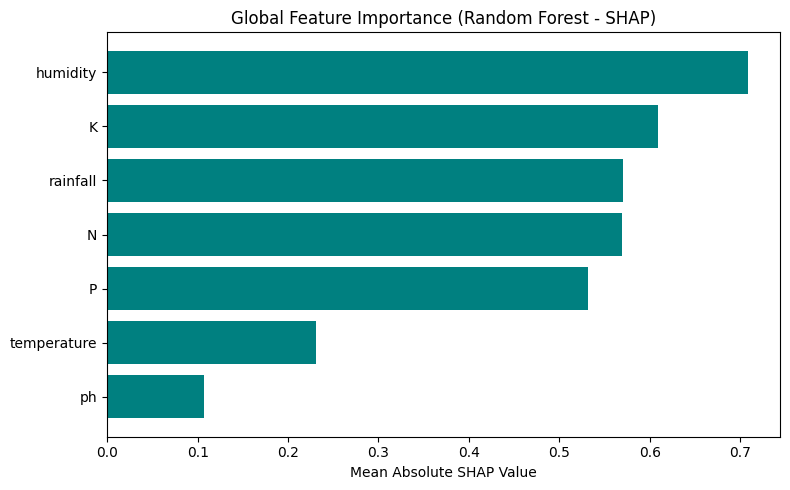


Global Feature Importance (Random Forest - SHAP) - Exact Values:


Feature  Mean_Absolute_SHAP
0     humidity            0.708604
1            K            0.608870
2     rainfall            0.570841
3            N            0.568995
4            P            0.531279
5  temperature            0.231127
6           ph            0.107440

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute mean absolute SHAP value for each feature ---
feature_importance_rf = np.mean(np.abs(shap_values_rf), axis=0)  # average across samples
sorted_idx_rf = np.argsort(feature_importance_rf)[::-1]  # sort descending

sorted_features_rf = [feature_names[i] for i in sorted_idx_rf]
sorted_importance_rf = feature_importance_rf[sorted_idx_rf]

# --- Plot horizontal bar chart ---
plt.figure(figsize=(8, 5))
plt.barh(sorted_features_rf, sorted_importance_rf, color='teal')
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Global Feature Importance (Random Forest - SHAP)")
plt.tight_layout()

plt.show()

# --- Print exact values for reference ---
import pandas as pd
rf_shap_importance_df = pd.DataFrame({
    "Feature": sorted_features_rf,
    "Mean_Absolute_SHAP": sorted_importance_rf
})
print("\nGlobal Feature Importance (Random Forest - SHAP) - Exact Values:")
display(rf_shap_importance_df)


Lime implementation for random forest model

In [68]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# --- Load train/test data (already preprocessed) ---
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')

# Create LIME explainer
lime_explainer_rf = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=label_encoder.classes_,
    mode='classification'
)

# Choose the same instance as SHAP (index 10)
instance_idx = 10
instance = X_test[instance_idx].reshape(1, -1)

# Generate LIME explanation
lime_exp_rf = lime_explainer_rf.explain_instance(
    data_row=X_test[instance_idx],
    predict_fn=rf_model.predict_proba,
    num_features=len(feature_names)
)

# Safe decoding for predicted crop
pred_class_rf = rf_model.predict(instance)[0]
try:
    pred_crop_rf = label_encoder.inverse_transform([pred_class_rf])[0]
except ValueError:
    pred_crop_rf = f"ClassCode-{pred_class_rf}"

# Display feature contributions
print(f"\nLIME Explanation for instance #{instance_idx} (Predicted crop: {pred_crop_rf})")
for feature, weight in lime_exp_rf.as_list():
    print(f"{feature}: {weight:.4f}")

# Show interactive HTML visualization (works in Colab)
lime_exp_rf.show_in_notebook(show_table=True)



LIME Explanation for instance #10 (Predicted crop: watermelon)
N > 0.93: 0.0717
P <= -0.77: -0.0498
0.41 < humidity <= 0.83: 0.0327
K > 0.02: 0.0209
rainfall <= -0.71: -0.0159
-0.66 < ph <= -0.05: 0.0079
-0.56 < temperature <= -0.02: -0.0079


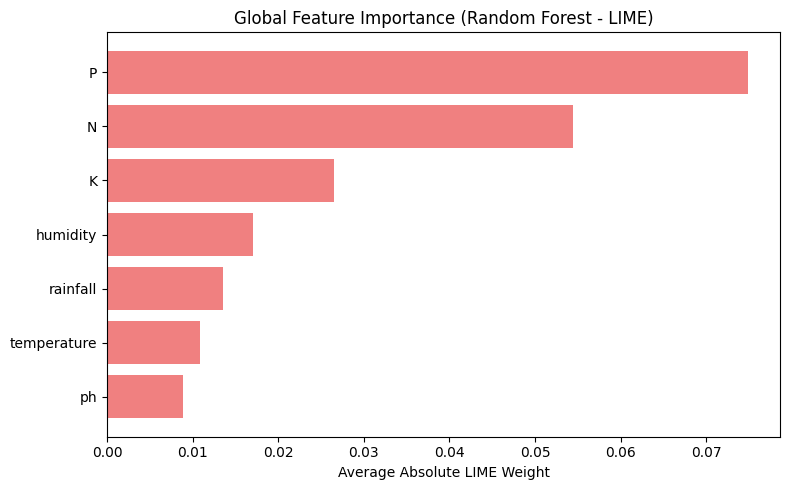


Global Feature Importance (Random Forest - LIME) - Exact Values:


Feature  Average_LIME_Weight
0            P             0.074881
1            N             0.054435
2            K             0.026524
3     humidity             0.017019
4     rainfall             0.013562
5  temperature             0.010854
6           ph             0.008901

In [69]:
import random
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Aggregate Global LIME Importance for Random Forest ---

# Use the full test set (or you can change num_samples to a subset for speed)
num_samples = len(X_test)
sample_indices = random.sample(range(len(X_test)), num_samples)

# Initialize dictionary to collect feature contributions
feature_contributions_rf = {feature: [] for feature in feature_names}

# Loop over sampled instances and collect absolute LIME weights
for idx in sample_indices:
    lime_exp = lime_explainer_rf.explain_instance(
        data_row=X_test[idx],
        predict_fn=rf_model.predict_proba,
        num_features=len(feature_names)
    )
    for feature, weight in lime_exp.as_list():
        # Extract only the feature name (ignore thresholds like "<= 0.5")
        match = re.match(r"([a-zA-Z_]+)", feature)
        if match:
            clean_feature = match.group(1)
            feature_contributions_rf[clean_feature].append(abs(weight))

# Compute average absolute importance for each feature
avg_importance_rf = {feature: np.mean(weights) for feature, weights in feature_contributions_rf.items()}

# Sort features by importance
sorted_features_rf_lime = sorted(avg_importance_rf, key=avg_importance_rf.get, reverse=True)
sorted_importance_rf_lime = [avg_importance_rf[f] for f in sorted_features_rf_lime]

# --- Plot the global LIME importance chart ---
plt.figure(figsize=(8, 5))
plt.barh(sorted_features_rf_lime, sorted_importance_rf_lime, color='lightcoral')
plt.gca().invert_yaxis()
plt.xlabel("Average Absolute LIME Weight")
plt.title("Global Feature Importance (Random Forest - LIME)")
plt.tight_layout()

# Save chart (optional)
plt.savefig("/content/drive/MyDrive/global_lime_importance_rf.png", dpi=300)
plt.show()

# --- Display exact values as a DataFrame ---
import pandas as pd
lime_importance_rf_df = pd.DataFrame({
    "Feature": sorted_features_rf_lime,
    "Average_LIME_Weight": sorted_importance_rf_lime
})
print("\nGlobal Feature Importance (Random Forest - LIME) - Exact Values:")
display(lime_importance_rf_df)


IG implementation of random forest using surrogate MLP

Epoch 10/50, Loss: 1.7509
Epoch 20/50, Loss: 0.8034
Epoch 30/50, Loss: 0.4129
Epoch 40/50, Loss: 0.2513
Epoch 50/50, Loss: 0.1753
Surrogate MLP (for Random Forest) Test Accuracy: 0.9682


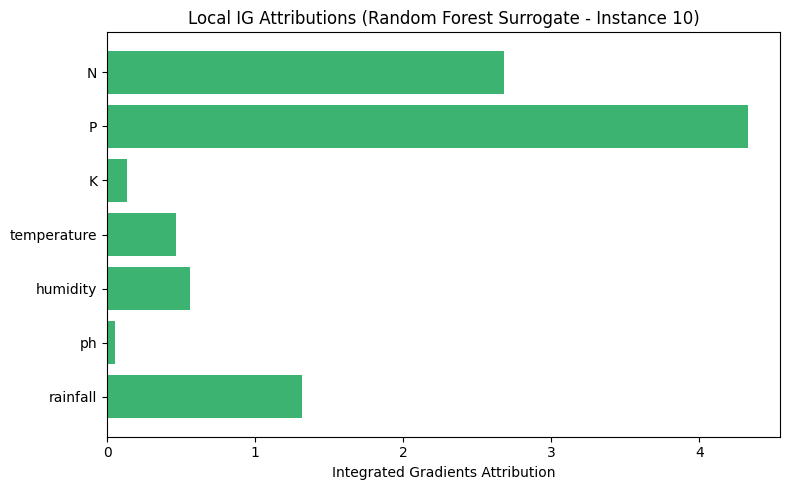


Exact IG Attributions (Random Forest Surrogate, Instance 10):
N: 2.681088
P: 4.329510
K: 0.136514
temperature: 0.462957
humidity: 0.561557
ph: 0.050447
rainfall: 1.313914


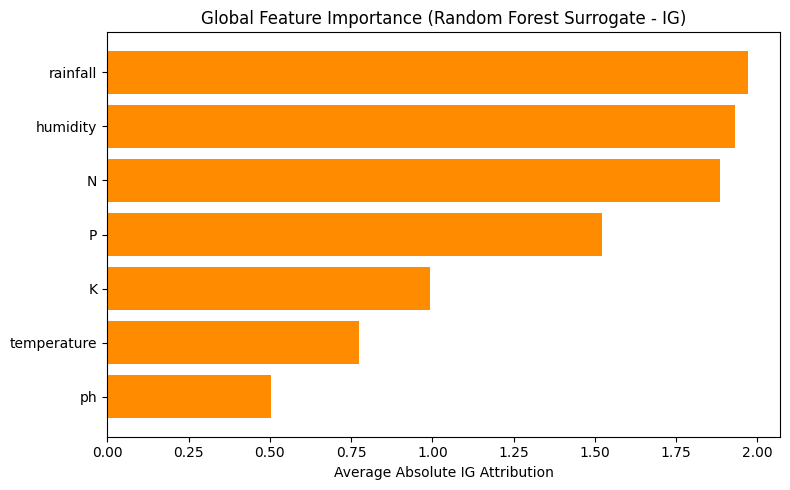


Global Feature Importance (Random Forest Surrogate - IG) - Exact Values:


Feature  Average_IG_Attribution
0     rainfall                1.970733
1     humidity                1.930979
2            N                1.886139
3            P                1.520260
4            K                0.991326
5  temperature                0.774432
6           ph                0.504604

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# --- Scale the data (if not already scaled) ---
scaler_rf = StandardScaler()
X_train_scaled_rf = scaler_rf.fit_transform(X_train)
X_test_scaled_rf = scaler_rf.transform(X_test)

# Labels are already numeric, so no re-encoding
y_train_encoded_rf = y_train
y_test_encoded_rf = y_test

# Convert to tensors
X_train_tensor_rf = torch.tensor(X_train_scaled_rf, dtype=torch.float32)
y_train_tensor_rf = torch.tensor(y_train_encoded_rf, dtype=torch.long)
X_test_tensor_rf = torch.tensor(X_test_scaled_rf, dtype=torch.float32)
y_test_tensor_rf = torch.tensor(y_test_encoded_rf, dtype=torch.long)

# --- Define a surrogate MLP for Random Forest ---
class SurrogateMLP_RF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=len(label_encoder.classes_)):
        super(SurrogateMLP_RF, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
input_dim_rf = X_train_tensor_rf.shape[1]
output_dim_rf = len(label_encoder.classes_)
mlp_model_rf = SurrogateMLP_RF(input_dim_rf, hidden_dim=64, output_dim=output_dim_rf)

criterion_rf = nn.CrossEntropyLoss()
optimizer_rf = optim.Adam(mlp_model_rf.parameters(), lr=0.01)

# --- Train the surrogate MLP ---
epochs = 50
mlp_model_rf.train()
for epoch in range(epochs):
    optimizer_rf.zero_grad()
    outputs = mlp_model_rf(X_train_tensor_rf)
    loss = criterion_rf(outputs, y_train_tensor_rf)
    loss.backward()
    optimizer_rf.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --- Evaluate accuracy ---
mlp_model_rf.eval()
with torch.no_grad():
    test_preds_rf = torch.argmax(mlp_model_rf(X_test_tensor_rf), dim=1)
    accuracy_rf = (test_preds_rf == y_test_tensor_rf).float().mean().item()
print(f"Surrogate MLP (for Random Forest) Test Accuracy: {accuracy_rf:.4f}")

# --- Integrated Gradients function (reuse from XGBoost) ---
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad = True
    outputs = model(scaled_inputs)
    target_outputs = outputs[:, target_class]
    grads = torch.autograd.grad(torch.sum(target_outputs), scaled_inputs)[0]
    avg_grads = grads[:-1].mean(dim=0)
    attributions = (input_tensor - baseline).squeeze() * avg_grads
    return attributions.detach().cpu().numpy()

# --- Local IG for instance 10 ---
instance_idx = 10
instance_rf = X_test_tensor_rf[instance_idx].unsqueeze(0)
pred_class_rf = torch.argmax(mlp_model_rf(instance_rf), dim=1).item()
ig_attributions_rf = integrated_gradients(mlp_model_rf, instance_rf, target_class=pred_class_rf)

# Plot local IG attributions
plt.figure(figsize=(8, 5))
plt.barh(feature_names, ig_attributions_rf, color='mediumseagreen')
plt.gca().invert_yaxis()
plt.xlabel("Integrated Gradients Attribution")
plt.title(f"Local IG Attributions (Random Forest Surrogate - Instance {instance_idx})")
plt.tight_layout()
plt.show()

# Print exact local values
print("\nExact IG Attributions (Random Forest Surrogate, Instance 10):")
for feature, value in zip(feature_names, ig_attributions_rf):
    print(f"{feature}: {value:.6f}")

# --- Global IG (average across all test instances) ---
all_ig_attributions_rf = []
for i in range(len(X_test_tensor_rf)):
    instance = X_test_tensor_rf[i].unsqueeze(0)
    pred_class = torch.argmax(mlp_model_rf(instance), dim=1).item()
    ig_attr = integrated_gradients(mlp_model_rf, instance, target_class=pred_class)
    all_ig_attributions_rf.append(np.abs(ig_attr))  # magnitude

all_ig_attributions_rf = np.array(all_ig_attributions_rf)
avg_ig_importance_rf = np.mean(all_ig_attributions_rf, axis=0)

# Sort by importance
sorted_idx_rf_ig = np.argsort(avg_ig_importance_rf)[::-1]
sorted_features_rf_ig = [feature_names[i] for i in sorted_idx_rf_ig]
sorted_importance_rf_ig = avg_ig_importance_rf[sorted_idx_rf_ig]

# Global IG bar plot
plt.figure(figsize=(8, 5))
plt.barh(sorted_features_rf_ig, sorted_importance_rf_ig, color='darkorange')
plt.gca().invert_yaxis()
plt.xlabel("Average Absolute IG Attribution")
plt.title("Global Feature Importance (Random Forest Surrogate - IG)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/global_ig_importance_rf.png", dpi=300)
plt.show()

# Print global values
ig_importance_rf_df = pd.DataFrame({
    "Feature": sorted_features_rf_ig,
    "Average_IG_Attribution": sorted_importance_rf_ig
})
print("\nGlobal Feature Importance (Random Forest Surrogate - IG) - Exact Values:")
display(ig_importance_rf_df)


Shap implementation for MLP

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Per-class SHAP shapes: [(440, 7, 22)]
Stacked shape: (1, 440, 7, 22)
Final combined shape: (440, 7, 22)
X_test_df shape: (440, 7)

Global Feature Importance (Bar Plot)...


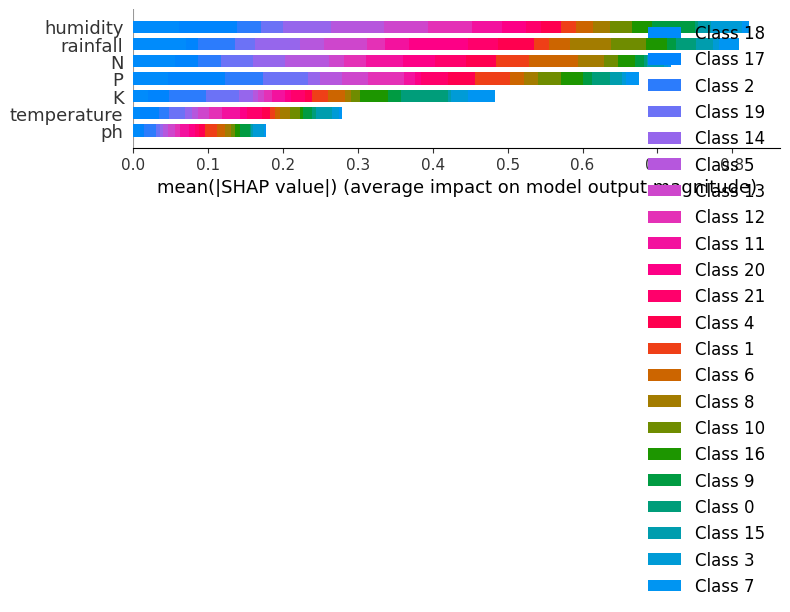


Global Feature Importance (Beeswarm - Combined)...


IndexError: index 18 is out of bounds for axis 1 with size 7

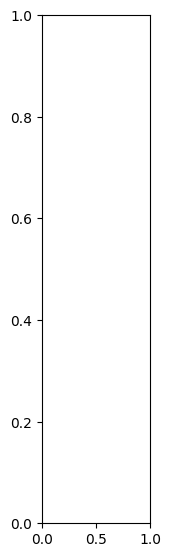

In [99]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load model and data ---
save_path = '/content/drive/MyDrive/'
mlp_model = joblib.load(save_path + 'MLP_model.pkl')
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- KernelExplainer for MLP ---
background_sample = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer_mlp = shap.KernelExplainer(mlp_model.predict_proba, background_sample)

# --- Compute SHAP values for all 440 rows in batches ---
batch_size = 50
all_shap_values = None

for start in range(0, len(X_test_df), batch_size):
    batch = X_test_df.iloc[start:start+batch_size]
    shap_batch = explainer_mlp.shap_values(batch, nsamples=batch_size)

    # Wrap as list if only 1 array returned (binary/simplified case)
    if not isinstance(shap_batch, list):
        shap_batch = [shap_batch]

    # Initialize storage for each class
    if all_shap_values is None:
        all_shap_values = [[] for _ in range(len(shap_batch))]

    # Fix orientation and append
    for cls_idx, arr in enumerate(shap_batch):
        if arr.shape[0] == len(feature_names):  # if (features × samples)
            arr = arr.T
        all_shap_values[cls_idx].append(arr)

# --- Concatenate all batches per class ---
shap_values_full = [np.vstack(v) for v in all_shap_values]  # each (440, 7)

# --- Combine across classes (absolute sum) for global view ---
stacked = np.stack(shap_values_full, axis=0)  # (num_classes, 440, 7)
shap_values_mlp_combined = np.sum(np.abs(stacked), axis=0)  # (440, 7)

# --- Detach SHAP metadata to prevent multi-class confusion ---
shap_values_clean = np.array(shap_values_mlp_combined).copy()
X_test_clean = np.array(X_test_df)  # also convert data to plain NumPy

print("Per-class SHAP shapes:", [v.shape for v in shap_values_full])
print("Stacked shape:", stacked.shape)
print("Final combined shape:", shap_values_clean.shape)
print("X_test_df shape:", X_test_df.shape)

# --------------------------
# --- GLOBAL PLOTS
# --------------------------

# 1) Global Feature Importance (Bar Plot)
print("\nGlobal Feature Importance (Bar Plot)...")
shap.summary_plot(
    shap_values_clean,
    X_test_clean,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# 2) Beeswarm Plot - Combined (metadata stripped, no IndexError)
print("\nGlobal Feature Importance (Beeswarm - Combined)...")
shap.summary_plot(
    shap_values_clean,
    X_test_clean,
    feature_names=feature_names,
    plot_type="dot",
    show=True
)

# 3) Beeswarm Plots - Per Class (detailed view)
for cls_idx, shap_arr in enumerate(shap_values_full):
    print(f"\nBeeswarm Plot for Class {cls_idx}...")
    shap_arr_clean = np.array(shap_arr).copy()
    shap.summary_plot(
        shap_arr_clean,
        X_test_clean,
        feature_names=feature_names,
        plot_type="dot",
        show=True
    )

# --------------------------
# --- LOCAL FORCE PLOT
# --------------------------
instance_idx = 10
instance_data = X_test_df.iloc[instance_idx].values.reshape(1, -1)
instance_true_class = y_test[instance_idx]
instance_pred_class = mlp_model.predict(instance_data)[0]

# Decode labels safely
try:
    true_crop_mlp = label_encoder.inverse_transform([instance_true_class])[0]
except ValueError:
    true_crop_mlp = f"Class-{instance_true_class}"
try:
    pred_crop_mlp = label_encoder.inverse_transform([instance_pred_class])[0]
except ValueError:
    pred_crop_mlp = f"Class-{instance_pred_class}"

print(f"\nExplaining instance #{instance_idx} for MLP")
print(f"True Crop: {true_crop_mlp} | Predicted Crop: {pred_crop_mlp}")

# SHAP values for predicted class for this instance
instance_shap_values = shap_values_full[instance_pred_class][instance_idx]

# Local force plot
shap.initjs()
shap.force_plot(
    base_value=explainer_mlp.expected_value[instance_pred_class]
    if isinstance(explainer_mlp.expected_value, (list, np.ndarray))
    else explainer_mlp.expected_value,
    shap_values=instance_shap_values,
    features=instance_data.flatten(),
    feature_names=feature_names
)


Lime implementation for mlp

Explaining Instance #10
True Crop: watermelon | Predicted Crop: watermelon

LIME Feature Weights (local explanation):
N > 0.93: 0.1472
P <= -0.77: -0.0868
K > 0.02: -0.0239
0.41 < humidity <= 0.83: 0.0219
rainfall <= -0.71: 0.0071
-0.66 < ph <= -0.05: 0.0043
-0.56 < temperature <= -0.02: 0.0042



Computing Global LIME Feature Importances (all test samples)...


Explaining with LIME: 100%|██████████| 440/440 [00:33<00:00, 13.32it/s]



Global LIME Feature Importance (averaged over all test samples):
       Feature  Avg_Abs_Weight
0            N        0.055409
1            P        0.051926
5           ph        0.028012
4     humidity        0.021985
6     rainfall        0.012370
2            K        0.006938
3  temperature        0.004750


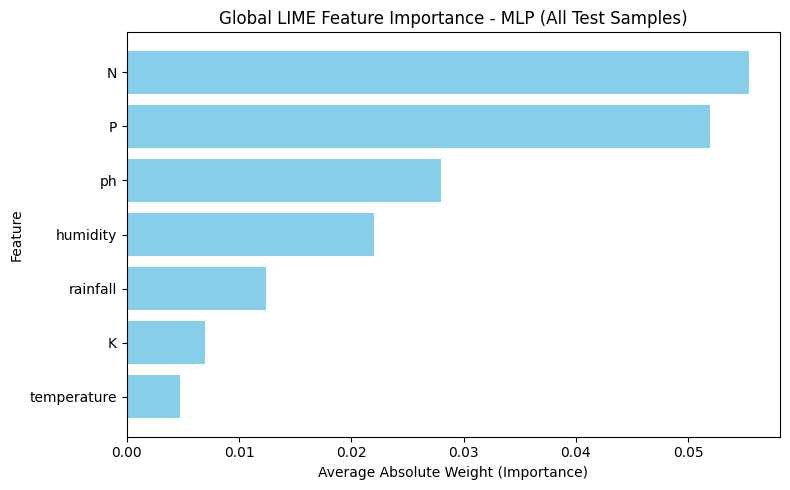

In [102]:
import joblib
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm  # for progress bar

# --- Load model and data ---
save_path = '/content/drive/MyDrive/'
mlp_model = joblib.load(save_path + 'MLP_model.pkl')
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# --- Set up LIME explainer ---
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=label_encoder.classes_,  # crop labels
    mode='classification'
)

# -------------------------------
# PART 1: LOCAL EXPLANATION (Instance 10)
# -------------------------------
instance_idx = 10
instance = X_test[instance_idx].reshape(1, -1)

pred_class = mlp_model.predict(instance)[0]
pred_class_label = label_encoder.inverse_transform([pred_class])[0]
true_class_label = label_encoder.inverse_transform([y_test[instance_idx]])[0]

print(f"Explaining Instance #{instance_idx}")
print(f"True Crop: {true_class_label} | Predicted Crop: {pred_class_label}")

exp = explainer_lime.explain_instance(
    data_row=X_test[instance_idx],
    predict_fn=mlp_model.predict_proba,
    num_features=len(feature_names)
)

print("\nLIME Feature Weights (local explanation):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Optional interactive visualization (works in Jupyter Notebook)
exp.show_in_notebook(show_table=True)

# -------------------------------
# PART 2: GLOBAL FEATURE IMPORTANCE (All Test Samples) - FIXED
# -------------------------------
print("\nComputing Global LIME Feature Importances (all test samples)...")

feature_importance = {fname: 0.0 for fname in feature_names}

for i in tqdm(range(len(X_test)), desc="Explaining with LIME"):
    exp_i = explainer_lime.explain_instance(
        data_row=X_test[i],
        predict_fn=mlp_model.predict_proba,
        num_features=len(feature_names)
    )
    for feature_condition, weight in exp_i.as_list():
        # Extract the base feature name (before any condition like <= or >)
        base_feature = feature_condition.split()[0]
        if base_feature in feature_importance:
            feature_importance[base_feature] += abs(weight)

# Normalize by number of samples
for feature in feature_importance:
    feature_importance[feature] /= len(X_test)

# Convert to DataFrame
lime_global_df = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Avg_Abs_Weight"]
).sort_values(by="Avg_Abs_Weight", ascending=False)

print("\nGlobal LIME Feature Importance (averaged over all test samples):")
print(lime_global_df)

# Optional: Bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(lime_global_df["Feature"], lime_global_df["Avg_Abs_Weight"], color='skyblue')
plt.xlabel("Average Absolute Weight (Importance)")
plt.ylabel("Feature")
plt.title("Global LIME Feature Importance - MLP (All Test Samples)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Shap implementation for svm

In [75]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load SVM model and test data ---
save_path = '/content/drive/MyDrive/'
svm_model = joblib.load(save_path + 'SVM_model.pkl')
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- KernelExplainer (sample background for speed) ---
background_sample = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer_svm = shap.KernelExplainer(svm_model.predict_proba, background_sample)

# Compute SHAP values for the test set
shap_values_svm = explainer_svm.shap_values(X_test_df, nsamples=100)  # list per class
shap_values_svm = np.array(shap_values_svm)  # (num_classes, num_samples, num_features)

# --- Collapse to 2D: sum absolute values across all classes ---
shap_values_svm_2d = np.abs(shap_values_svm).sum(axis=0)  # (num_samples, num_features)

print("Final SHAP matrix (for plot) shape:", shap_values_svm_2d.shape)
print("X_test_df shape:", X_test_df.shape)

# --- Global SHAP Summary Plot (safe) ---
print("\nGenerating SHAP summary plot for SVM...")
shap.summary_plot(shap_values_svm_2d, X_test_df.values, feature_names=feature_names, show=True)

# --- Local SHAP Force Plot (Instance 10) ---
instance_idx = 10
instance_data = X_test_df.iloc[instance_idx].values.reshape(1, -1)
instance_true_class = y_test[instance_idx]
instance_pred_class = svm_model.predict(instance_data)[0]

# Decode labels safely
try:
    true_crop_svm = label_encoder.inverse_transform([instance_true_class])[0]
except ValueError:
    true_crop_svm = f"ClassCode-{instance_true_class}"
try:
    pred_crop_svm = label_encoder.inverse_transform([instance_pred_class])[0]
except ValueError:
    pred_crop_svm = f"ClassCode-{instance_pred_class}"

print(f"\nExplaining instance #{instance_idx} for SVM")
print(f"True Crop: {true_crop_svm} | Predicted Crop: {pred_crop_svm}")

# Pick SHAP values for the predicted class only
class_index = instance_pred_class
instance_shap_values = shap_values_svm[class_index][instance_idx]

shap.initjs()
shap.force_plot(
    base_value=explainer_svm.expected_value[class_index],
    shap_values=instance_shap_values,
    features=instance_data.flatten(),
    feature_names=feature_names
)


  0%|          | 0/440 [00:00<?, ?it/s]

Final SHAP matrix (for plot) shape: (7, 22)
X_test_df shape: (440, 7)

Generating SHAP summary plot for SVM...


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Lime implementation of SVM

Explaining Instance #10
True Crop: watermelon | Predicted Crop: watermelon

LIME Feature Weights (local explanation):
N > 0.93: 0.1233
P <= -0.77: -0.0830
K > 0.02: 0.0283
rainfall <= -0.71: -0.0264
0.41 < humidity <= 0.83: 0.0217
-0.66 < ph <= -0.05: 0.0080
-0.56 < temperature <= -0.02: -0.0062



Computing Global LIME Feature Importances (all test samples)...


Explaining with LIME: 100%|██████████| 440/440 [02:53<00:00,  2.54it/s]



Global LIME Feature Importance (averaged over all test samples):
       Feature  Avg_Abs_Weight
1            P        0.053077
0            N        0.049172
5           ph        0.019489
4     humidity        0.017667
3  temperature        0.010738
2            K        0.010474
6     rainfall        0.009924


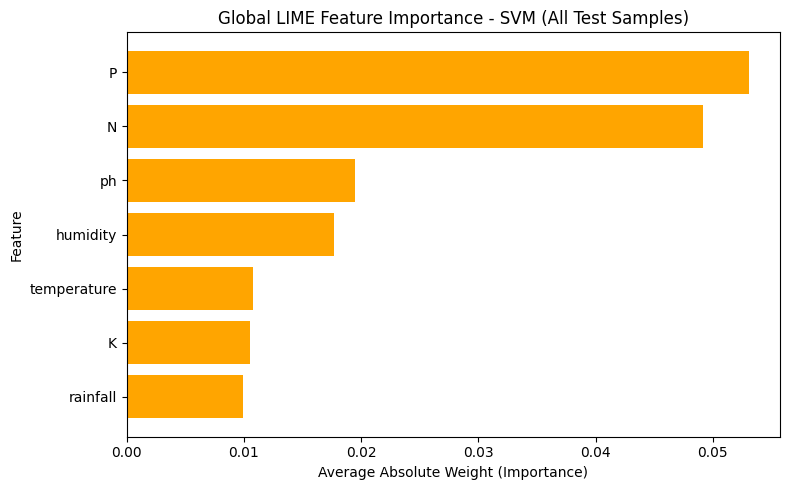

In [103]:
import joblib
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm  # for progress display
import matplotlib.pyplot as plt

# --- Load SVM model and data ---
save_path = '/content/drive/MyDrive/'
svm_model = joblib.load(save_path + 'SVM_model.pkl')
X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# --- Set up LIME explainer ---
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=label_encoder.classes_,  # original crop labels
    mode='classification'
)

# -------------------------------
# PART 1: LOCAL EXPLANATION (Instance 10)
# -------------------------------
instance_idx = 10
instance = X_test[instance_idx].reshape(1, -1)

pred_class = svm_model.predict(instance)[0]
pred_class_label = label_encoder.inverse_transform([pred_class])[0]
true_class_label = label_encoder.inverse_transform([y_test[instance_idx]])[0]

print(f"Explaining Instance #{instance_idx}")
print(f"True Crop: {true_class_label} | Predicted Crop: {pred_class_label}")

exp = explainer_lime.explain_instance(
    data_row=X_test[instance_idx],
    predict_fn=svm_model.predict_proba,
    num_features=len(feature_names)
)

print("\nLIME Feature Weights (local explanation):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Optional: Interactive visualization (works in Colab/Jupyter)
exp.show_in_notebook(show_table=True)

# -------------------------------
# PART 2: GLOBAL FEATURE IMPORTANCE (All Test Samples)
# -------------------------------
print("\nComputing Global LIME Feature Importances (all test samples)...")

feature_importance = {fname: 0.0 for fname in feature_names}

for i in tqdm(range(len(X_test)), desc="Explaining with LIME"):
    exp_i = explainer_lime.explain_instance(
        data_row=X_test[i],
        predict_fn=svm_model.predict_proba,
        num_features=len(feature_names)
    )
    for feature_condition, weight in exp_i.as_list():
        # Extract base feature name (ignore conditions like "N <= 0.5")
        base_feature = feature_condition.split()[0]
        if base_feature in feature_importance:
            feature_importance[base_feature] += abs(weight)

# Normalize by sample count
for feature in feature_importance:
    feature_importance[feature] /= len(X_test)

# Convert to DataFrame for easier visualization
lime_global_df = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Avg_Abs_Weight"]
).sort_values(by="Avg_Abs_Weight", ascending=False)

print("\nGlobal LIME Feature Importance (averaged over all test samples):")
print(lime_global_df)

# --- Bar chart visualization ---
plt.figure(figsize=(8, 5))
plt.barh(lime_global_df["Feature"], lime_global_df["Avg_Abs_Weight"], color='orange')
plt.xlabel("Average Absolute Weight (Importance)")
plt.ylabel("Feature")
plt.title("Global LIME Feature Importance - SVM (All Test Samples)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
